# COSMO Project - Regressions
By Mathilde Raynal, Etienne Bonvin and Xavier Pantet

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from regressions import *
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
DATA_FOLDER = "data/"
X = np.load(DATA_FOLDER + "pca_x.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

np.random.seed(1)

In [4]:
print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (30049, 3004)
y: (30049,)


## Idea 1: Good ol' least squares (MSE loss without regularizer)

We first try a standard and naive implementation of `least_squares` on the full dataset:

In [5]:
def run_least_squares():
    w_star = least_squares(y, X)
    loss = rmse(y, X, w_star)
    print("Loss = " + str(loss))

run_least_squares()

Loss = 26.166553759575127


We see that the loss is quite large! We hope to do better using polynomial expansion using a smaller dataset composed only of a smaller number of features so that we don't need a cluster. We use 4-fold cross-validation to find the best `degree`:

In [6]:
k_fold = 4
k_indices = build_k_indices(y, k_fold)

def run_least_squares_poly():
    rmse_tr = []
    rmse_te = []

    for degree in range(4):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, least_squares)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))
    pd.DataFrame([rmse_tr, rmse_te]).add_prefix("Degree ").rename({0: "Train error", 1: "Test error"}).head()
    return rmse_tr, rmse_te

In [7]:
run_least_squares_poly()

([3.214363737341961,
  0.5956012277327409,
  0.4661340477548795,
  0.3562751890194217],
 [3.214384303727872,
  0.7107496454416272,
  0.7489895213565038,
  1.0423134308771025])

Indeed, polynomial expansion provides better results. Moreover, we see that the best `degree` is 1.

__By adding a single feature of constant values, we manage to decrease the RMSE from 26 to 0.7!__

## Idea 2: Ridge regression (MSE loss with $\mathcal{L}_2$-regularizer)

In [8]:
k_fold = 4
k_indices = build_k_indices(y, k_fold)

def run_ridge_regression():
    for lambda_ in np.logspace(-5, 1, 7):
        print("Lambda = " + str(lambda_))
        for degree in range(1, 3):
            print("    Degree = " + str(degree))
            rmse_tr_tmp = []
            rmse_te_tmp = []
            for k in range(k_fold):
                ridge_lambda = lambda y, X: ridge_regression(y, X, lambda_)
                loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, ridge_lambda)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            print("        " + str(np.mean(rmse_tr_tmp)))
            print("        " + str(np.mean(rmse_te_tmp)))

In [9]:
run_ridge_regression()

Lambda = 1e-05
    Degree = 1
        0.5956012277327412
        0.7107496453242187
    Degree = 2
        0.46613404775498773
        0.7489895167328673
Lambda = 0.0001
    Degree = 1
        0.5956012277327529
        0.7107496442675574
    Degree = 2
        0.46613404776569345
        0.7489894751442037
Lambda = 0.001
    Degree = 1
        0.595601227733922
        0.7107496337022221
    Degree = 2
        0.46613404883618903
        0.7489890616490246
Lambda = 0.01
    Degree = 1
        0.5956012278508356
        0.7107495281758753
    Degree = 2
        0.46613415581978157
        0.7489851656593154
Lambda = 0.1
    Degree = 1
        0.5956012395420908
        0.7107484856140888
    Degree = 2
        0.4661447884335308
        0.748969941829664
Lambda = 1.0
    Degree = 1
        0.5956024085635065
        0.7107393300294402
    Degree = 2
        0.4671445127958839
        0.751035239705691
Lambda = 10.0
    Degree = 1
        0.5957191962706814
        0.7107746313203024
  

We see that the best test error is achieved with a regulizer of $\lambda = 10^{-5}$ for `degree 1` and $\lambda = 10^{-2}$ for `degree 2`. In all cases, `degree 1` remains our best degree value.

Since the results are almost equal with and without a regulizer and provided that the test error increases for larger values of $\lambda$, we deduce that the model is not overfitted and that a $\mathcal{L}_2$ regulizer is useless...

## Idea 3: Lasso (MSE loss with $\mathcal{L}_1$-regularizer)

In [10]:
def run_lasso():
    for lambda_ in np.concatenate([[0], np.logspace(-5, 2, 8)]):
        print("lambda = " + str(lambda_))
        for degree in range(1, 3):
            print("    degree = " + str(degree))
            rmse_tr_tmp = []
            rmse_te_tmp = []
    
            for k in range(k_fold):
                lasso_lambda = lambda y, X, w: lasso(y, X, w, lambda_)
                lasso_stoch_grad_lambda = lambda y, X, w: lasso_stoch_grad(y, X, w, lambda_)
                loss_lambda = lambda y, X: stochastic_gradient_descent(y, X, np.zeros(X.shape[1]), 100, 1e-2, lasso_lambda, lasso_stoch_grad_lambda, batch_size = 100)
                loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, loss_lambda)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            print("        " + str(np.mean(rmse_tr_tmp)))
            print("        " + str(np.mean(rmse_te_tmp)))

Before we run it, we try a `stochastic_gradient_descent` using a `lasso`, just to see what we can expect:

In [11]:
lambda_ = 0
lasso_lambda = lambda y, X, w: lasso(y, X, w, lambda_)
lasso_stoch_grad_lambda = lambda y, X, w: lasso_stoch_grad(y, X, w, lambda_)
_, losses = stochastic_gradient_descent(y, X, np.zeros(X.shape[1]), 500, 1e-3, lasso_lambda, lasso_stoch_grad_lambda, batch_size = 100, detail = True)

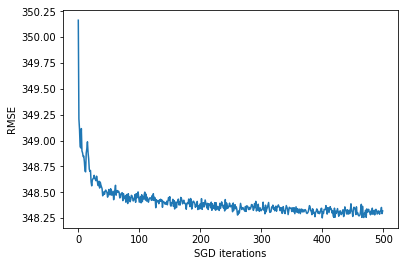

In [12]:
plt.xlabel("SGD iterations")
plt.ylabel("RMSE")
plt.plot(losses)

In [13]:
print(np.argmin(losses))
print(losses[np.argmin(losses)])

400
348.25213134943533


Looking at the result, we see that convergence is really slow. Indeed, since $\lambda = 0$, we are basically optimizing a standard MSE for which we know (from above) that the optimal solution is 16. We deduce it is unlikely to do better than `ridge_regression`, and we drop this idea.

## Idea 4: MAE loss (with SGD) with $\mathcal{L}_2$-regularizer 

In [14]:
def run_mae_sgd():
    for lambda_ in [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
        print("lambda = " + str(lambda_))
        for degree in range(1, 3):
            print("    degree = " + str(degree))
            rmse_tr_tmp = []
            rmse_te_tmp = []
            
            lambda_mae = lambda y, X, w: mae(y, X, w, lambda_)
            lambda_mae_stoch_grad = lambda y, X, w: mae_stoch_grad(y, X, w, lambda_)
            for k in range(k_fold):
                mae_lambda = lambda y, X: stochastic_gradient_descent(y, X, np.zeros(X.shape[1]), 500, 1, lambda_mae, lambda_mae_stoch_grad, batch_size = 100)
                loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, mae_lambda)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            print("        " + str(np.mean(rmse_tr_tmp)))
            print("        " + str(np.mean(rmse_te_tmp)))

Again, we first try to validate the method before we run that.

Degree 1
    loss = 26.157978949178226
Degree 2
    loss = 16.19609756269716


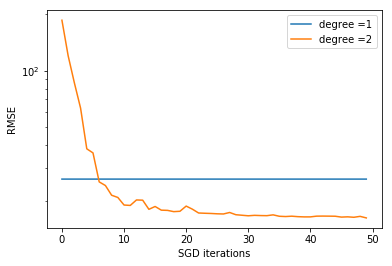

In [15]:
for i in range(1, 3):
    lambda_ = 0
    print("Degree " + str(i))
    X_ = build_poly(X, i)
    lambda_mae = lambda y, X, w: mae(y, X, w, lambda_)
    lambda_grad_mae = lambda y, X, w: mae_stoch_grad(y, X, w, lambda_)
    ws, losses = stochastic_gradient_descent(y, X_, np.zeros(X_.shape[1]), 50, 1, lambda_mae, lambda_grad_mae, batch_size = 100, detail = True)
    plt.xlabel("SGD iterations")
    plt.ylabel("RMSE")
    plt.semilogy(losses, label = "degree =" + str(i))
    plt.legend()
    print("    loss = " + str(losses[np.argmin(losses)]))

The loss obtained reaches RMSE of approx. 15 for degree 2 polynomial expansion. We think that we probably won't be able to do better than ridge regression, but the effort is worth trying. Degree 3 has been tested separately and gives RMSE > 1000, hence we exclude it from the possible degree candidates.

In [16]:
run_mae_sgd()

lambda = 0
    degree = 1
        26.35371994925645
        26.354889491590473
    degree = 2
        22.515068535407593
        21.827205839959223
lambda = 1e-06
    degree = 1
        26.353553644134728
        26.35524896392704
    degree = 2
        18.469397229515472
        19.14784731920851
lambda = 1e-05
    degree = 1
        26.353381647220083
        26.355726307919657
    degree = 2
        17.766083950064917
        17.058207713236126
lambda = 0.0001
    degree = 1
        26.35347529092474
        26.35544271644942
    degree = 2
        47.69551001365905
        33.91302291539178
lambda = 0.001
    degree = 1
        26.35348188909042
        26.355600823490235
    degree = 2
        20.388617999582586
        18.20426598564456
lambda = 0.01
    degree = 1
        26.35357530094729
        26.355806538704133
    degree = 2
        18.835697415577194
        19.39820948120436
lambda = 0.1
    degree = 1
        26.354726499564283
        26.355648366412233
    degree = 2


As expected, we see that the results are not as good as ridge regression...